In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Phase 3: Visualize the high-dimensional trajectory of an optimizer using PCA.


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]
Training Progress: 100%|██████████| 15/15 [03:33<00:00, 14.25s/it]


Explained variance by top 3 components: 94.10%


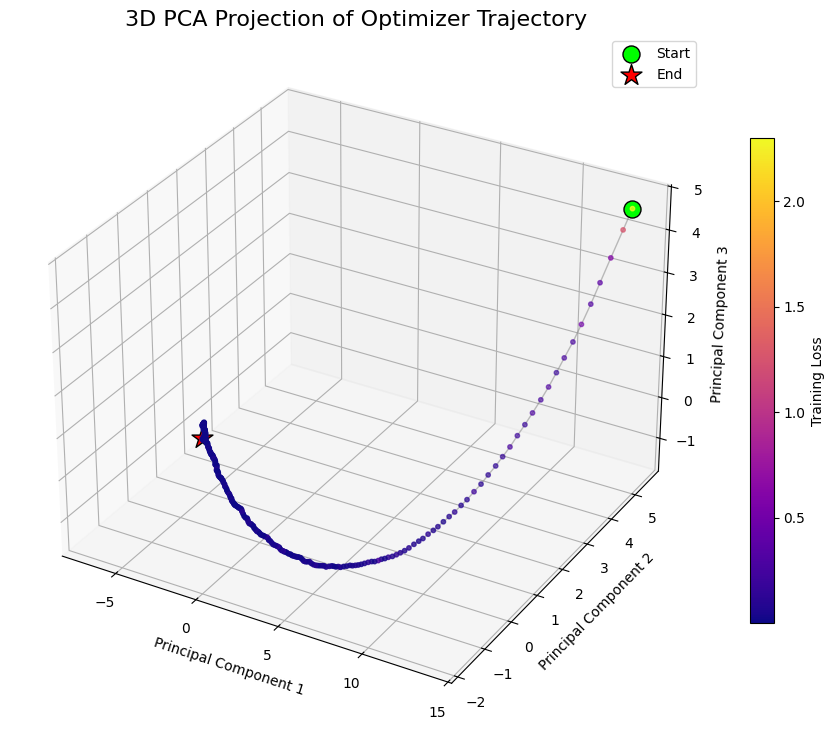

In [2]:
# A LeNet-style CNN is trained on MNIST
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(256, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

NUM_EPOCHS = 15
LEARNING_RATE = 0.001
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                               ])),
    batch_size=BATCH_SIZE, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

parameter_history = []
loss_history = []

def get_flat_params(model):
    return torch.cat([p.detach().flatten() for p in model.parameters()]).cpu().numpy()

# The flattened parameter vector at high frequency during training
global_step = 0
SAVE_FREQUENCY = 20

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress"):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        if global_step % SAVE_FREQUENCY == 0:
            parameter_history.append(get_flat_params(model))
            loss_for_color = criterion(model(images), labels)
            loss_history.append(loss_for_color.item())

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        global_step += 1

# PCA on the recorded history to find the 3 directions of highest variance
param_matrix = np.array(parameter_history)
pca = PCA(n_components=3)
projected_trajectory = pca.fit_transform(param_matrix)
print(f"Explained variance by top 3 components: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Project the entire trajectory onto these top 3 principal components
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Color the path by the training loss to show progress over time
colors = loss_history
sc = ax.scatter(projected_trajectory[:, 0],
                projected_trajectory[:, 1],
                projected_trajectory[:, 2],
                c=colors,
                cmap='plasma',
                marker='o',
                s=10)

ax.plot(projected_trajectory[:, 0],
        projected_trajectory[:, 1],
        projected_trajectory[:, 2],
        color='gray', alpha=0.5, linewidth=1)

ax.scatter(projected_trajectory[0, 0], projected_trajectory[0, 1], projected_trajectory[0, 2],
           marker='o', s=150, color='lime', label='Start', depthshade=False, ec='black')
ax.scatter(projected_trajectory[-1, 0], projected_trajectory[-1, 1], projected_trajectory[-1, 2],
           marker='*', s=250, color='red', label='End', depthshade=False, ec='black')

cbar = fig.colorbar(sc, ax=ax, shrink=0.7)
cbar.set_label('Training Loss')
ax.set_title("3D PCA Projection of Optimizer Trajectory", fontsize=16)
ax.set_xlabel("Principal Component 1", fontsize=10)
ax.set_ylabel("Principal Component 2", fontsize=10)
ax.set_zlabel("Principal Component 3", fontsize=10)
ax.legend()
plt.show()